In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("GodoyAula5") \
    .getOrCreate()

In [6]:
df_review = spark.read.format("json").option("header", "true").load("./amazon-music-reviews.json")

In [7]:
df_ab = spark.read.format("csv").option("header", "true").load("ab_test.csv")

In [8]:
def pshow(sparkDf, limit=10):
    return sparkDf.limit(limit).toPandas()

In [11]:
pshow(df_review, 3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800


In [12]:
pshow(df_ab, 3)

,_c0,userId,experiment,alternative,conversion
0,0,A1FW17CFR34TKF,ab_test,A,1
1,1,A2ZAEMRNIA7PV6,ab_test,A,0
2,2,AZ39SOZT3NZQU,ab_test,A,0


In [13]:
df_joined = df_review.join(df_ab, df_review["reviewerID"] == df_ab["userID"], "left")

In [15]:
pshow(df_joined, 3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,_c0,userId,experiment,alternative,conversion
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200,267,A3EBHHCZO6V2A4,ab_test,A,0
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400,3271,AZPWAXJG9OJXV,ab_test,A,1
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800,680,A38IRL0X2T4DPF,ab_test,A,1


In [26]:
from pyspark.sql import functions as F

df_joined_grouped = df_joined.filter("alternative is not null").groupBy("alternative").avg("overall")
#     .agg(
#         F.mean("overall").alias("overall_mean")
#     )

pshow(df_joined_grouped)

,alternative,avg(overall)
0,B,4.224297
1,A,4.220563


In [27]:
from pyspark.sql.functions import from_unixtime

df_formated = df_joined.withColumn("month",
                                  from_unixtime(
                                      df_joined["unixReviewTime"], format="MM"
                                  ))

In [29]:
pshow(df_formated, 3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,_c0,userId,experiment,alternative,conversion,month
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200,267,A3EBHHCZO6V2A4,ab_test,A,0,09
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400,3271,AZPWAXJG9OJXV,ab_test,A,1,06
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800,680,A38IRL0X2T4DPF,ab_test,A,1,07


In [32]:
from  pyspark.sql.functions import count, sum

df_ic = (df_formated
        .filter("alternative is not null")
         .groupBy("alternative", "month")
         .agg(
             count("*").alias("impressions"), 
             sum(df_formated["conversion"]).cast("long").alias("conversions")
         )
        )
    
pshow(df_ic)

,alternative,month,impressions,conversions
0,A,12,2914,1143
1,B,10,2713,829
2,A,05,2808,1051
3,A,01,2911,1158
4,A,02,2616,976
5,A,08,2475,999
6,B,07,2673,909
7,A,06,2594,950
8,A,07,2811,1083
9,B,05,2550,811


In [36]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf

def conversion_rate(imp, conv):
    i = float(imp)
    c = float(conv)
    return c/i

conversion_rate_udf = udf(conversion_rate, DoubleType())

In [40]:
df_rate = (df_ic.withColumn(
            "rate", 
            conversion_rate_udf(df_ic["impressions"], df_ic["conversions"])
        ).orderBy("month", "alternative"))

pshow(df_rate)

,alternative,month,impressions,conversions,rate
0,A,01,2911,1158,0.397801
1,B,01,2633,875,0.332321
2,A,02,2616,976,0.373089
3,B,02,2599,808,0.310889
4,A,03,2949,1085,0.367921
5,B,03,2847,989,0.347383
6,A,04,2755,1001,0.363339
7,B,04,2574,779,0.302642
8,A,05,2808,1051,0.374288
9,B,05,2550,811,0.318039


In [42]:
import seaborn as sns

df_plot = df_rate.toPandas()

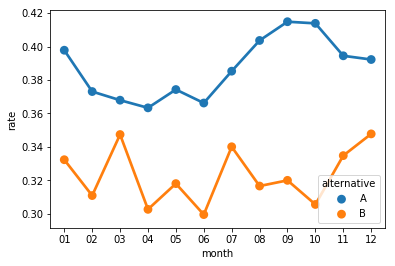

In [45]:
%matplotlib inline
sns.pointplot(x="month", y="rate", hue="alternative", data=df_plot)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59917315c0>,
      dtype=object)

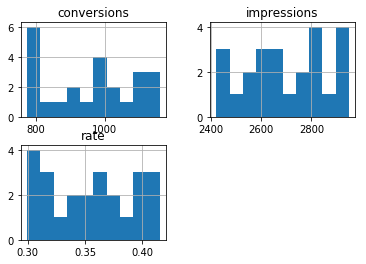

In [46]:
df_plot.hist()

In [47]:
from scipy import stats

In [56]:
from pyspark.sql.types import FloatType

df_peso_normal = spark.read.format("csv").option("header", "true").load("ex_pecas_normal.csv")

df_peso_lote_novo = spark.read.format("csv").option("header", "true").load("ex_pecas_novo_lote.csv")

In [57]:
pshow(df_peso_lote_novo, 3)

,peso
0,101.52525316476179
1,103.26290969139829
2,97.35008277949453


In [59]:
df_peso_normal_float = df_peso_normal.select(df_peso_normal["peso"].cast("float"))
df_peso_lote_novo_float = df_peso_lote_novo.select(df_peso_lote_novo["peso"].cast("float"))

In [61]:
pshow(df_peso_lote_novo_float, 3)

,peso
0,101.525253
1,103.262909
2,97.350082


In [63]:
df_pandas_peso_normal = df_peso_normal_float.toPandas()
df_pandas_peso_lote_novo = df_peso_lote_novo_float.toPandas()

In [67]:
_, pvalue = (stats.ttest_ind(df_pandas_peso_normal["peso"],
                           df_pandas_peso_lote_novo["peso"]
                          )
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f599154df28>]],
      dtype=object)

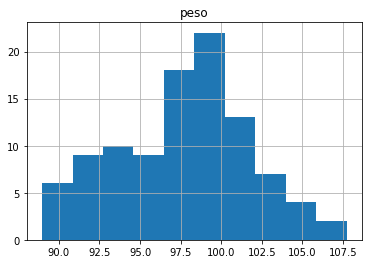

In [70]:
df_pandas_peso_lote_novo.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59915e8978>]],
      dtype=object)

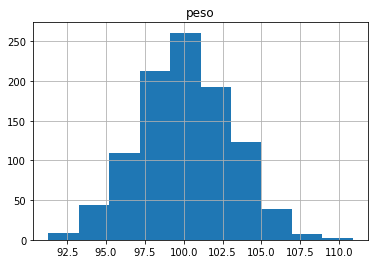

In [69]:
df_pandas_peso_normal.hist()

In [72]:
if(pvalue >= 0.05):
    print("Aceito que são iguais estatisticamente!")
else:
    print("Rejeito que são iguais estatisticamente.")
    
pvalue

Rejeito que são iguais estatisticamente.


5.020480028264646e-13

Faça teste t para avaliar se as taxas de conversão mensais são de fato diferentes

In [94]:
pshow(df_rate, 3)

,alternative,month,impressions,conversions,rate
0,A,01,2911,1158,0.397801
1,B,01,2633,875,0.332321
2,A,02,2616,976,0.373089


In [90]:
# df_rate_means = df_rate.groupBy("alternative").agg(F.mean("rate").alias("rate_mean"))
df_rate_a = df_rate.filter(df_rate["alternative"] == "A").select(df_rate["rate"].cast("float"))
df_rate_b = df_rate.filter(df_rate["alternative"] == "B").select(df_rate["rate"].cast("float"))

df_rate_a_pandas = df_rate_a.toPandas()
df_rate_b_pandas = df_rate_b.toPandas()

In [91]:
df_rate_a_pandas

,rate
0,0.397801
1,0.373089
2,0.367921
3,0.363339
4,0.374288
5,0.366230
6,0.385272
7,0.403636
8,0.414845
9,0.413867


In [95]:
_, pvalue = (stats.ttest_ind(df_rate_a_pandas["rate"], df_rate_b_pandas["rate"]))

In [96]:
pvalue

9.813476247340778e-09

In [97]:
if(pvalue >= 0.05):
    print("Aceito que são iguais estatisticamente!")
else:
    print("Rejeito que são iguais estatisticamente.")
    

Rejeito que são iguais estatisticamente.


## Lift

`lift = 100*(taxB - taxA)/taxA`


## Window function

In [98]:
from pyspark.sql.window import Window
from pyspark.sql.functions import first, when, round, col, collect_list

In [99]:
w = Window().partitionBy("month").orderBy("alternative")

In [102]:
pshow(df_rate, 4)

,alternative,month,impressions,conversions,rate
0,A,01,2911,1158,0.397801
1,B,01,2633,875,0.332321
2,A,02,2616,976,0.373089
3,B,02,2599,808,0.310889


In [106]:
df_rate_window = df_rate.select("*", first("rate").over(w).alias("control_rate"))

In [107]:
pshow(df_rate_window)

,alternative,month,impressions,conversions,rate,control_rate
0,A,07,2811,1083,0.385272,0.385272
1,B,07,2673,909,0.340067,0.385272
2,A,11,2819,1112,0.394466,0.394466
3,B,11,2763,925,0.334781,0.394466
4,A,01,2911,1158,0.397801,0.397801
5,B,01,2633,875,0.332321,0.397801
6,A,09,2425,1006,0.414845,0.414845
7,B,09,2422,775,0.319983,0.414845
8,A,05,2808,1051,0.374288,0.374288
9,B,05,2550,811,0.318039,0.374288


In [108]:
df_w = df_rate.withColumn("control_rate", when(df_rate["alternative"]=="A", 0).otherwise(first("rate").over(w)))

In [109]:
pshow(df_w)

,alternative,month,impressions,conversions,rate,control_rate
0,A,07,2811,1083,0.385272,0.000000
1,B,07,2673,909,0.340067,0.385272
2,A,11,2819,1112,0.394466,0.000000
3,B,11,2763,925,0.334781,0.394466
4,A,01,2911,1158,0.397801,0.000000
5,B,01,2633,875,0.332321,0.397801
6,A,09,2425,1006,0.414845,0.000000
7,B,09,2422,775,0.319983,0.414845
8,A,05,2808,1051,0.374288,0.000000
9,B,05,2550,811,0.318039,0.374288


In [110]:
df_lift_month = (df_w.withColumn("lift", 100*(col("rate")-col("control_rate"))/col("control_rate")))

In [112]:
pshow(df_lift_month, 24)

,alternative,month,impressions,conversions,rate,control_rate,lift
0,A,07,2811,1083,0.385272,0.000000,NaN
1,B,07,2673,909,0.340067,0.385272,-11.733214
2,A,11,2819,1112,0.394466,0.000000,NaN
3,B,11,2763,925,0.334781,0.394466,-15.130599
4,A,01,2911,1158,0.397801,0.000000,NaN
5,B,01,2633,875,0.332321,0.397801,-16.460698
6,A,09,2425,1006,0.414845,0.000000,NaN
7,B,09,2422,775,0.319983,0.414845,-22.866804
8,A,05,2808,1051,0.374288,0.000000,NaN
9,B,05,2550,811,0.318039,0.374288,-15.028152
